<div class="alert alert-info" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
<font size="5"><b><center>Yandex Hackathon: Result by Team № 4</center></b></font>

**Данный ноутбук посвящён сравнению результатов, полученных с помощью разработанного алгоритма, с рекомендациями старой системы и непосредственным решением сотрудника склада:**


**Сравнение будет проходить по двум параметрам:**

 - **Затраты на упаковку**
  - **Занимаемый объем при транспортировке**


#  Загрузка библиотек

In [1]:
import pandas as pd
import numpy as np
import pickle
import os
from tqdm import tqdm, notebook

from matplotlib.gridspec import GridSpec
from matplotlib.patches import Patch
import matplotlib.pyplot as plt
import seaborn as sns

import scipy
from scipy.sparse import csr_matrix
from statistics import mean


import joblib
import faiss
from faiss import read_index

import warnings
import sys

warnings.filterwarnings("ignore")
notebook.tqdm().pandas()

0it [00:00, ?it/s]

# Подготовка инструментов

In [2]:
cwd = os.getcwd()

In [3]:
cwd

'/Users/greygreywolf/Documents/yandex_market_hackaton_team_4'

**Пути к данным, моделям, масштабизаторам**

In [4]:
PATH_DATA = cwd + '/initial_data/data.csv'
PATH_SKU = cwd + '/initial_data/sku.csv'
PATH_SKU_CARGOTYPES = cwd + '/initial_data/sku_cargotypes.csv'
PATH_CARTON = cwd + '/initial_data/carton.csv'
PATH_CARGOTYPES_INFO = cwd + '/initial_data/cargotype_info.csv'
PATH_CARTON_PRICE = cwd + '/initial_data/carton_price.xlsx'

In [5]:
PATH_TO_SAVE_SCALER_CLASIFIC = cwd + '/for_docker_images/src/scalers/scaler_rb_for_clusific.bin'
PATH_TO_SAVE_SCALER_FOR_CLUSTER = cwd + '/for_docker_images/src/scalers/scaler_rb_for_cluster.bin'
PATH_TO_SAVE_TFIDF_VECTORIZER = cwd + '/for_docker_images/src/vectorizers/tfidf_vectorizer.bin'
PATH_TO_OHE = cwd + "/for_docker_images/src/scalers/encoder.bin"

In [6]:
PATH_TO_SAVE_CLUSTERING_MODEL = cwd + "/for_docker_images/src/models/clustering_model.pkl"
PATH_TO_SAVE_FAISS = cwd + "/for_docker_images/src/models/fiass_index_with_drop_columns.index"
PATH_TO_SAVE_COLUMNS_TO_DROP = cwd + "/for_docker_images/src/models/columns_to_drop"
PATH_TO_COLUMNS_TARGET = cwd + '/for_docker_images/src/models/target.csv'

**Для преобразования датасета возьмем функции описанные в тетрадке с моделированием.**

In [7]:
def forming_df_for_tfidf(df_in):
    df = df_in.copy(deep=True)
    df['cargotype'] = df['cargotype'].astype('str')
    df_for_tfidf = df[['sku', 'cargotype']]
    df_for_tfidf['cargotype'] = df_for_tfidf['cargotype'] + ' '
    df_for_tfidf = df_for_tfidf.groupby('sku')['cargotype'].agg('sum').reset_index(drop=False)
    return df_for_tfidf

In [8]:
def sorted_dementions_sku(df):
    df['list_demensions'] = df.apply(lambda x: sorted([x['a'], x['b'], x['c']]), axis=1)
    df['a'] = df.apply(lambda x: x['list_demensions'][0], axis=1)
    df['b'] = df.apply(lambda x: x['list_demensions'][1], axis=1)
    df['c'] = df.apply(lambda x: x['list_demensions'][2], axis=1)
    df.drop('list_demensions', axis=1, inplace=True)
    return df

In [9]:
def get_tfidf_dataframe(df, tfidf):
    tfidf_matrix = tfidf.transform(df['cargotype'])
    dict_for_columns = {i[1]: i[0] for i in tfidf.vocabulary_.items()}
    new_df = pd.DataFrame.sparse.from_spmatrix(tfidf_matrix).rename(columns=dict_for_columns)
    new_df.insert(0, 'sku', df['sku'])
    new_df['no_cargotype'] = (df['cargotype'] == '').astype('int')
    return new_df

In [10]:
def get_df_for_cluster(df, tfidf, scaler):
    new_df = df.copy(deep=True)
    df_cargotype = get_tfidf_dataframe(new_df[['sku', 'cargotype']], tfidf)
    new_df = new_df[['sku', 'a', 'b', 'c']]
    new_df['volume'] = new_df['a'] * new_df['b'] * new_df['c']
    new_df = new_df.merge(df_cargotype.drop_duplicates(), how='left', on='sku')
    new_df['no_cargotype'] = (df['cargotype'] == '').astype('int')
    new_df['no_size'] = ((new_df['a'].values == 0) &
                         (new_df['b'].values == 0) &
                         (new_df['c'].values == 0)).astype('int')
    new_df[['a', 'b', 'c', 'volume']] = scaler.transform(new_df[['a', 'b', 'c', 'volume']])
    new_df.drop(['sku'], axis=1, inplace=True)
    return new_df

In [11]:
def get_weight_size_charact(df):
    new_df = df.copy(deep=True)
    new_df['specific_weight'] = new_df['goods_wght'] / new_df['volume']
    new_df['specific_weight'] = new_df['specific_weight'].fillna(0)
    new_df.loc[new_df['specific_weight'] == np.inf, 'specific_weight'] = sys.maxsize
    new_df = new_df.fillna(0)
    return new_df

In [12]:
def get_df_for_predict(df, tfidf, scaler, column_drop):
    new_df = df[['sku', 'a', 'b', 'c', 'cluster']]
    new_df['volume'] = new_df['a'] * new_df['b'] * new_df['c']
    new_df['no_size'] = ((df['a'].values == 0) &
                         (df['b'].values == 0) &
                         (df['c'].values == 0)).astype('int')
    new_df = sorted_dementions_sku(new_df)
    df_tfidf = get_tfidf_dataframe(df[['sku', 'cargotype']], tfidf)
    new_df = new_df.merge(df_tfidf, how='left', on='sku')
    new_df['goods_wght'] = df['goods_wght']
    new_df = get_weight_size_charact(new_df)
    new_df[['a', 'b', 'c', 'volume', 'goods_wght', 'specific_weight']] = scaler.transform(
        new_df[['a', 'b', 'c', 'volume', 'goods_wght', 'specific_weight']])
    columns_for_ohe = ['cluster_' + str(i) for i in encoder.categories_[0]]
    new_df[columns_for_ohe] = encoder.transform(new_df['cluster'].values.reshape(-1, 1)).toarray()
    new_df.drop('cluster', axis=1, inplace=True)
    new_df = new_df.drop(column_drop, axis=1)
    new_df = new_df.drop('sku', axis=1)
    return new_df

In [13]:
def get_bool_list_ib_list(list1, list2):
    res = False
    for carton in list1:
            if carton in list2:
                res = True
    return res

In [14]:
def get_fit_predict_list_n(index, x_test, k=20, n=3, one_row=True):
    xq_x_test = x_test.values.astype('float32')
    dem, ind = index.search(xq_x_test, k)
    predicted_list = []
    for candidates in ind:
        predict = []
        for candidate in candidates:
            if id_base_dict[candidate] not in predict:
                predict.append(id_base_dict[candidate])
        predicted_list.append(predict[:n])
    if one_row:
        return list(np.array(predicted_list).reshape(-1, ))
    return predicted_list

In [15]:
LIST_BIG_CARTON = ['STRETCH', 'NONPACK']

**Загрузим масштабизаторы, веторизатор и модели**

In [16]:
scaler_clasific = joblib.load(PATH_TO_SAVE_SCALER_CLASIFIC)
scaler_claster = joblib.load(PATH_TO_SAVE_SCALER_FOR_CLUSTER)
tfidf = joblib.load(PATH_TO_SAVE_TFIDF_VECTORIZER)

In [17]:
with open(PATH_TO_SAVE_CLUSTERING_MODEL, 'rb') as file:
    kmeans = pickle.load(file)

with open(PATH_TO_SAVE_COLUMNS_TO_DROP, 'rb') as file:
    column_drop = pickle.load(file)
    
with open(PATH_TO_OHE, 'rb') as file:
    encoder = pickle.load(file)
    
    
target = (pd.read_csv(PATH_TO_COLUMNS_TARGET))['target']
id_base_dict = dict(target.reset_index(drop=True))
ind = read_index(PATH_TO_SAVE_FAISS)

**Загрузим исходные данные и подготовим их для использования разработанного алгоритма**

In [18]:
df_data = pd.read_csv(PATH_DATA, index_col=0)
df_sku = pd.read_csv(PATH_SKU, index_col=0)
df_sku_cargotypes = pd.read_csv(PATH_SKU_CARGOTYPES, index_col=0)
df_carton = pd.read_csv(PATH_CARTON, index_col=0)
df_carton_price = pd.read_excel(PATH_CARTON_PRICE, names=['cartontype', 'price'])

In [19]:
df_sku_cargotypes.query('sku == "af49bf330e2cf16e44f0be1bdfe337bd"')

,sku,cargotype
12633828,af49bf330e2cf16e44f0be1bdfe337bd,290
12633829,af49bf330e2cf16e44f0be1bdfe337bd,600
12633830,af49bf330e2cf16e44f0be1bdfe337bd,610
12633831,af49bf330e2cf16e44f0be1bdfe337bd,950
12633832,af49bf330e2cf16e44f0be1bdfe337bd,970
12633833,af49bf330e2cf16e44f0be1bdfe337bd,980


# Предобработка датасета

**Обработаем датасет с карготипами, что бы учесть наличие несколих карготипов для каждого товара**

In [20]:
df_sku_cargotypes.query('sku == "4862bf0e760a593b13f3f2fcf822e533"')

,sku,cargotype
0,4862bf0e760a593b13f3f2fcf822e533,290
1,4862bf0e760a593b13f3f2fcf822e533,901


In [21]:
df_sku_cargotypes = forming_df_for_tfidf(df_sku_cargotypes)

In [22]:
df_sku_cargotypes.query('sku == "4862bf0e760a593b13f3f2fcf822e533"')

,sku,cargotype
1791785,4862bf0e760a593b13f3f2fcf822e533,290 901


**Удалим лишние признаки**

In [23]:
df_data.drop(['selected_cartontype', 'recommended_cartontype',
              'who', 'trackingid', 'whs'], axis=1, inplace=True)

**Присоеденим остальные признаки. Несмотря на то, что разработанный алгоритм работает с любыми размерами из датасета, в нем присутсвуют типы упаковок, которых нет в словаре с ценами. В дальнейшем это может помешать оценить затраченную на упавку стоимость, поэтому удалим такие типы.**

In [24]:
full_df = df_data.merge(df_sku, how='left', on='sku')
full_df = full_df.merge(df_sku_cargotypes, how='left', on='sku')

In [25]:
full_df = df_data.merge(df_sku, how='left', on='sku')
full_df = full_df.merge(df_sku_cargotypes, how='left', on='sku')
full_df = full_df[full_df['selected_carton'].isin(df_carton_price.cartontype.unique().tolist())]
full_df = full_df[full_df['recommended_carton'].isin(df_carton_price.cartontype.unique().tolist())]
full_df.reset_index(drop=True, inplace=True)

**Рассчет стоимость текущего датасета займет значительное время, ограничемся последними 60 строками**

In [26]:
trancated_df = full_df[276848:276908].copy(deep=True)
trancated_df.reset_index(drop=True, inplace=True)
trancated_df.dropna(axis=0, inplace=True)

**Обработаме текущий датасет**

In [27]:
trancated_df.sort_values(by=['orderkey'], inplace=True)
trancated_df.reset_index(drop=True, inplace=True)

In [28]:
for_analysis = trancated_df.copy(deep=True)
trancated_df.drop(['orderkey', 'selected_carton', 'recommended_carton', 'pack_volume', 'box_num', 'sel_calc_cube', 'rec_calc_cube'], axis=1, inplace=True)
trancated_df = trancated_df[['sku', 'a', 'b', 'c', 'goods_wght', 'cargotype']]

In [29]:
df_sku_cargot_str = forming_df_for_tfidf(trancated_df)
trancated_df = trancated_df.drop(['cargotype'], axis=1).merge(df_sku_cargot_str, how='left', on='sku')

In [30]:
trancated_df = sorted_dementions_sku(trancated_df)
df_for_claster = get_df_for_cluster(trancated_df, tfidf, scaler_claster)
trancated_df['cluster'] = kmeans.predict(df_for_claster)

# Обработка датасета с помощью текущего алгоритма

**Используем алгоритм для группировки товаров и выбора упаковки для каждого заказа из набора данных**

In [31]:
dct_wth_orders = {}

In [32]:
for order in for_analysis['orderkey'].unique().tolist():
    df_for_order_analysis = for_analysis.query('orderkey == @order')
    first_index_df = df_for_order_analysis.index[0]
    last_index_df = df_for_order_analysis.index[-1]
    if first_index_df == last_index_df:
        df_for_order_for_alg = trancated_df.loc[[first_index_df]]
    elif first_index_df != last_index_df:
        df_for_order_for_alg = trancated_df[first_index_df:last_index_df]
    list_answer = []
    # перебираем кластеры по очереди
    for cluster in sorted(df_for_order_for_alg['cluster'].unique()):
        df_cluster = df_for_order_for_alg[df_for_order_for_alg['cluster'] == cluster]
    # Отсортируем df_cluster по объёму
        df_cluster['volume'] = df_cluster['a'] * df_cluster['b'] * df_cluster['c']
        df_cluster = df_cluster.sort_values('volume', ascending=False)
        df_cluster = df_cluster.drop('volume', axis=1)
    # сбросим индексы
        df_cluster = df_cluster.reset_index(drop=True)
    # Создадим словарь с текущей стопкой sku товаров
        list_sku = []
        while df_cluster.shape[0] != 0:
            dict_sku = {}
            index_for_drop = [0]  # для записи индексов товаров, которые упакованы
            # делаем текущим айтемом первую строку, добавляем её в текущий список sku
            item = df_cluster.iloc[:1]
            old_item = item.copy(deep=True)
            list_sku.append(item.loc[0]['sku'])
            # проводим предобработку sku в формат для предсказания и делаем прогноз
            item = get_df_for_predict(item, tfidf, scaler_clasific, column_drop)
            predict = get_fit_predict_list_n(ind, item)
            # Проверяем не один ли товар в ордере, если один, то предиктим, добавляем в словарь, и выходим из цикла
            if df_cluster.shape[0] == 1:
                dict_sku[' '.join(map(str, list_sku))] = predict
                list_answer.append(dict_sku)
                break
            # Проверяем не был ли товар крупногабаритным по упаковке, если был, то просто добавляем в словарь и дропаем его из датасета
            if get_bool_list_ib_list(LIST_BIG_CARTON, predict):
                dict_sku[' '.join(map(str, list_sku))] = predict
                list_answer.append(dict_sku)
                df_cluster = df_cluster[df_cluster.index != 0]
                df_cluster = df_cluster.reset_index(drop=True)
                list_sku = []
            else:
            # если товар не был крупногабаритным, то перебираем все оставшиеся товары, чтобы доукомплектовать коробку
                for i in range(1, df_cluster.shape[0]):
                # Выбираем наименьший размер текущего айтема и доавляем кнему наименьший размер следующего
                    new_item = df_cluster.iloc[i:i + 1]
                    new_item_sku = new_item.loc[i]['sku']
                    new_item['a'] = old_item['a'].values + new_item['a'].values
                    # после этого переопределяем наибольший размер по оставшимся двум измерениям
                    new_item['b'] = max(old_item['b'].values, new_item['b'].values)
                    new_item['c'] = max(old_item['c'].values, new_item['c'].values)
                    # определяем вес объединенного айтема
                    new_item['goods_wght'] = old_item['goods_wght'].values + new_item['goods_wght'].values
                    # определяем новый карготип товара, для этого объединяем карготипы двух рассматриваемых товаров,
                    # разделяем их в список, находим уникальные вхождения при помощи множеств, объединяем обратно в строку
                    new_item['cargotype'] = ' '.join(set((old_item.loc[0]['cargotype'] + new_item.loc[i]['cargotype']).split()))
                    # проводим предобработку sku в формат для предсказания и делаем прогноз
                    item_for_pred = get_df_for_predict(new_item.reset_index(drop=True),
                                                       tfidf,
                                                       scaler_clasific,
                                                       column_drop)
                    predict_list = get_fit_predict_list_n(ind, item_for_pred)
                    # если новый товар не крупногабаритный, тогда добавляем его в список супер товара
                    # и дропаем второй товар из df_cluster
                    if not get_bool_list_ib_list(LIST_BIG_CARTON, predict_list):
                        list_sku.append(new_item_sku)
                        index_for_drop.append(i)
                        old_item = new_item.reset_index(drop=True)
                            # удаляем объект, обнуляем индексы
                df_cluster = df_cluster[~df_cluster.index.isin(index_for_drop)]
                df_cluster = df_cluster.reset_index(drop=True)
                old_item_for_pred = get_df_for_predict(old_item,
                                                       tfidf,
                                                       scaler_clasific,
                                                       column_drop)
                # После обхода добавляем в словарь очередной набор
                dict_sku[' '.join(map(str, list_sku))] = get_fit_predict_list_n(ind, old_item_for_pred)
                list_answer.append(dict_sku)
                list_sku = []
    dct_wth_orders[order] = list_answer

# Сравнение результатов

## Сравнение цен 

**Сравним затраты на упаковку рекомендованные разработанным алгоритмом с затратами, основанные на выборе человека и рекомендациях предшествующей системы.**

**Создадим словарь цен упаковок**

In [33]:
dict_wth_price = dict(zip(df_carton_price.cartontype, df_carton_price.price))
dict_wth_price

{'MYA': 1.10986120605469,
 'MYB': 2.29743245442708,
 'MYC': 3.61671256510417,
 'MYD': 6.91837518601191,
 'MYE': 8.06272243923611,
 'MYF': 4.08313023663949,
 'YMA': 4.39293721516927,
 'YMC': 7.77748710436699,
 'YME': 23.6702600549768,
 'YMF': 10.6614871294071,
 'YMG': 17.4663671875,
 'YML': 37.6945662313433,
 'YMW': 13.8700002034505,
 'YMX': 28.48125,
 'YMY': 40.9111781529018}

**Далее вычислим затраты на паковку рекмендованную предшествующим алгоритмом, и выбранную упаковщиком**

In [34]:
for_analysis['selected_price'] = for_analysis['selected_carton'].apply(lambda x: dict_wth_price[x] if x not in LIST_BIG_CARTON else 0)
for_analysis['recomended_price'] = for_analysis['recommended_carton'].apply(lambda x: dict_wth_price[x] if x not in LIST_BIG_CARTON else 0)

**Рассчитаем затраты по результатам работы нового алгоритма, но перед этим сагрегируем полученные результаты**

In [35]:
for_analysis_by_order = for_analysis.groupby('orderkey')['selected_price','recomended_price'].sum().reset_index()

**Для рассчета цен по результатм финальном алгоритма будем брать первую из трех предложенных упаковок.**

In [36]:
for_analysis_by_order['now_price'] = 0
for num_order, sku_and_cartontype in dct_wth_orders.items():
    for dct in sku_and_cartontype:
        for _ , lst_wth_cartontype in dct.items():
            if lst_wth_cartontype[0] in LIST_BIG_CARTON:
                for_analysis_by_order.loc[for_analysis_by_order['orderkey'] == num_order, 'now_price'] += 0
            elif lst_wth_cartontype[0] not in LIST_BIG_CARTON:  
                for_analysis_by_order.loc[for_analysis_by_order['orderkey'] == num_order, 'now_price'] += dict_wth_price[lst_wth_cartontype[0]]

In [37]:
for_analysis_by_order

,orderkey,selected_price,recomended_price,now_price
0,0e4f34db53e37d6bf171c2e055e2b4e0,7.233425,15.554974,2.297432
1,0f7044e79cb62222396cc81e4ce53e10,3.616713,7.777487,2.297432
2,207fca032df1ef3ff517b7460a9be52f,23.332461,23.332461,6.918375
3,2eb73fa9fd34c6b85a47082d0efe6fca,4.392937,4.392937,2.297432
4,3acc4b901256bcd9f333b6978864773b,7.777487,7.777487,1.109861
5,40cb76ed7064202a5b8a5ce9cbfb1de4,13.836750,47.340520,2.297432
6,4207ef10bd059f8b57a5796657d4cccc,40.313612,87.331836,4.594865
7,4b311935811db1e95e60a13f7876f4dc,15.554974,15.554974,2.297432
8,5d71fcf9bc99aa8a1cc3cfb76f4f678b,16.125445,47.340520,2.297432
9,741bdd8e6a671176d33b174552aaafea,6.918375,7.777487,3.616713


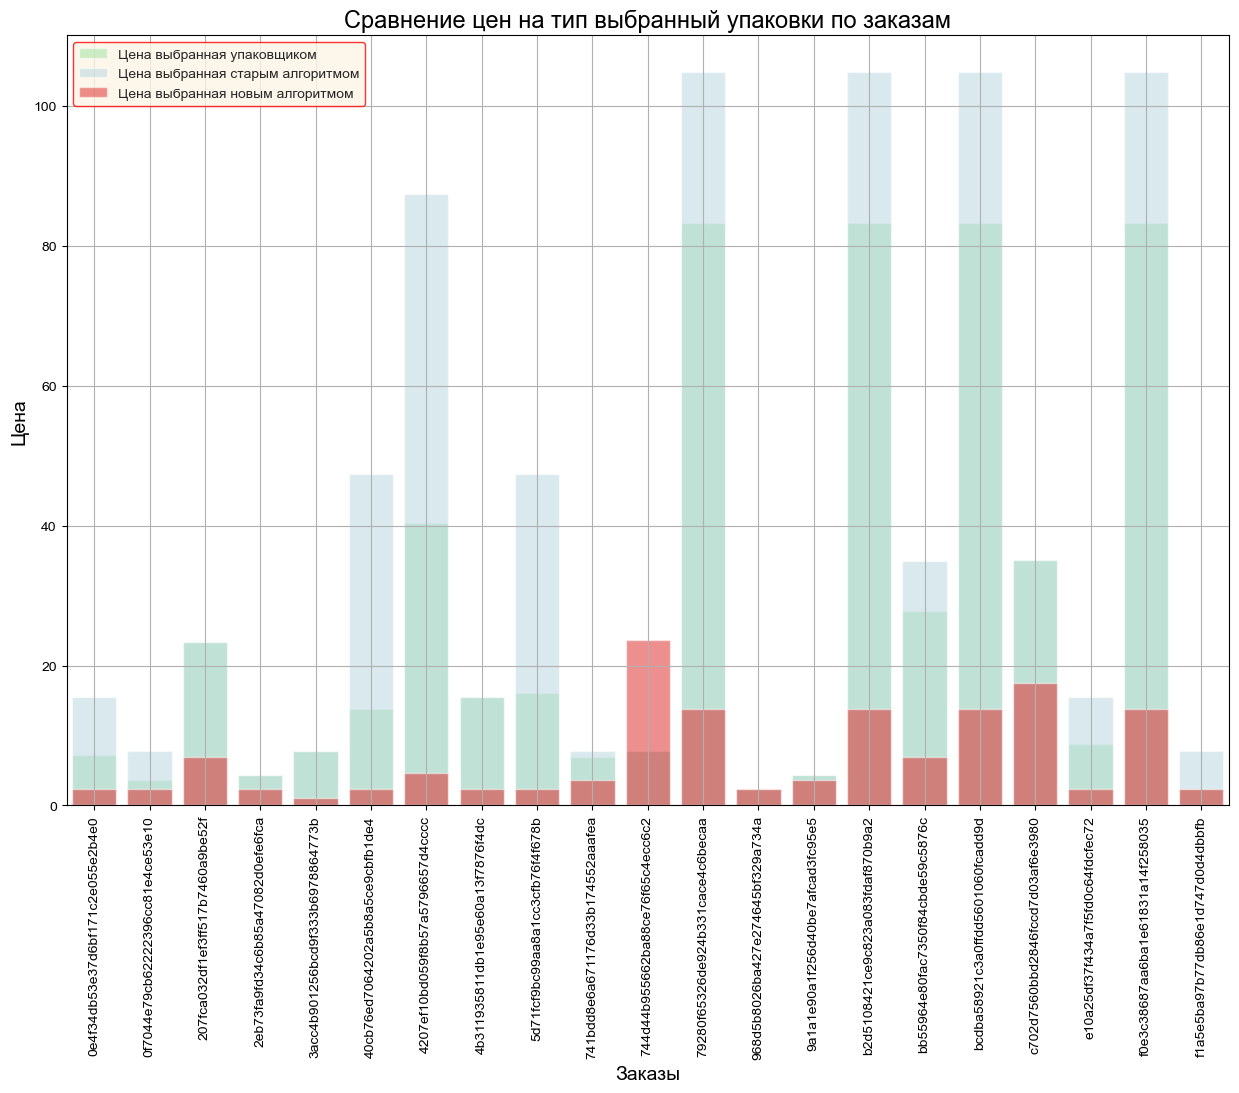

In [38]:
plt.figure(figsize=(15, 10))
plt.title('Сравнение цен на тип выбранный упаковки по заказам', fontsize=17)
sns.set_style('darkgrid')
sns.barplot(data=for_analysis_by_order,
            x=for_analysis_by_order.orderkey,
            y='selected_price',
            color='lightgreen',
            alpha=0.5,
            label = 'Цена выбранная упаковщиком')
sns.barplot(data=for_analysis_by_order,
            x=for_analysis_by_order.orderkey,
            y='recomended_price',
            alpha=0.5,
            color='lightblue',
            label = 'Цена выбранная старым алгоритмом')
sns.barplot(data=for_analysis_by_order,
            x=for_analysis_by_order.orderkey,
            y='now_price',
            alpha=0.5,
            color='red',
            label = 'Цена выбранная новым алгоритмом')
plt.ylabel('Цена', fontsize=14)
plt.xlabel('Заказы', fontsize=14)
plt.xticks(rotation=90)
plt.grid(True)
plt.legend(edgecolor = 'r',
           facecolor = 'oldlace');

In [39]:
dct_wth_orders['744d44b955662ba88ce76f65c4ecc6c2']

[{'4d4734cd71d9b24871f37c7df29c2ed9': ['YME', 'MYC', 'NONPACK']}]

**Из графика выше можно сделать вывод, что для большинства заказов текущий алгоритм выбирает наименьшую по стоимости упаковку, в том числе немаловажную роль играет группировка товаров. В отдельных случая , как с заказом выше новая цена превышает предыдущую. Так как модель обучалась из соображений не только экономии пространства и стоимости упаковки, но и сохранения надлежащего качества товара во время доставки, первый варинт рекомендации значительно дороже того, что был ранее. Так же стоит обратить внимание на то, что в рекомендациях присутствуют три варианта, среди которых есть "NONPACK". В подобных случаях упаковщику следует учитывать качества товара и выбрать подходящий варинат. Так же можно предположить, что количество товаров с такими характеристками в датасете значительно мало, и модель могла недостаточно обучится работе с этим типом.**

**В дополнениеследует отметить, что старая рекомендательная система почти всегда предлогала самую дорогую упаковку. Упаковщик выбирал менее затратные варианты.**

In [40]:
total_price = for_analysis_by_order[['selected_price','recomended_price','now_price']].agg('sum').reset_index().rename(columns={'index': 'price', 0: 'value'})

In [41]:
total_price

,price,value
0,selected_price,560.416847
1,recomended_price,791.250047
2,now_price,144.040804


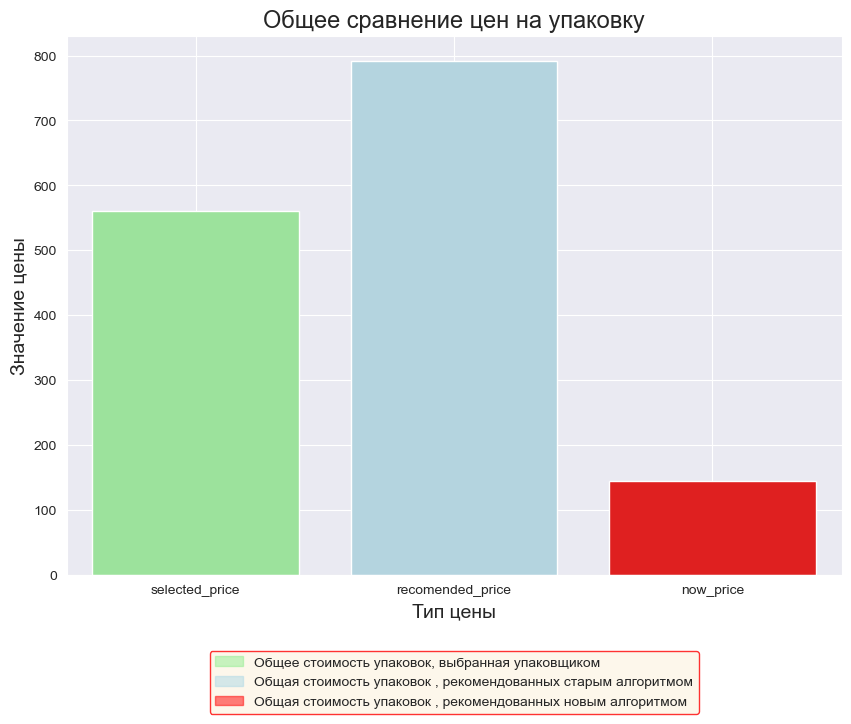

In [42]:
plt.figure(figsize=(10, 7))
plt.title('Общее сравнение цен на упаковку', fontsize=17)
sns.set_style('darkgrid')
sns.barplot(data=total_price,
            x='price',
            y='value',
            palette=['lightgreen', 'lightblue', 'red'])
plt.ylabel('Значение цены', fontsize=14)
plt.xlabel('Тип цены', fontsize=14)
plt.grid(True)
plt.legend(handles=[Patch(color='lightgreen', alpha=.5, label=f'Общее стоимость упаковок, выбранная упаковщиком'),
                    Patch(color='lightblue', alpha=.5, label=f'Общая стоимость упаковок , рекомендованных старым алгоритмом'),
                    Patch(color='red', alpha=.5, label=f'Общая стоимость упаковок , рекомендованных новым алгоритмом')],
           edgecolor = 'r',
           facecolor = 'oldlace', 
           loc='center',
           bbox_to_anchor=(0.5, -0.2));

**Общая значение расходов на упаковки, рекомендованные новым алгоритмом, значительно ниже рекомендаций старого алгоритма и выбора упавощика**

## Сравнение объема

**Теперь сравним объем упакованных товаров**

In [43]:
df_carton = df_carton.reset_index()

**Вычислим объем для упаковок**

In [44]:
df_carton['volume'] = df_carton['LENGTH'] * df_carton['WIDTH'] * df_carton['HEIGHT']

**Создадим словарь размеров упаковок.**

In [45]:
dict_wth_volume = dict(zip(df_carton.CARTONTYPE, df_carton.volume))

In [46]:
dict_wth_volume

{'YMA': 3705.0,
 'YMC': 9000.0,
 'YME': 40050.0,
 'YMF': 13125.0,
 'YMG': 26820.0,
 'YMH': 72240.0,
 'YMJ': 69600.0,
 'KSD': 0.0,
 'YML': 108000.0,
 'YMN': 144000.0,
 'YMO': 58500.0,
 'YMP': 46200.0,
 'YMQ': 168000.0,
 'YMR': 384000.0,
 'YMS': 263599.875,
 'NONPACK': 0.0,
 'STRETCH': 0.0,
 'YMU': 2592.0,
 'YMV': 4292.0,
 'YMW': 18000.0,
 'YMХ': 46800.0,
 'MYF': 1500.0,
 'YMX': 46800.0,
 'YMY': 72800.0,
 'MYA': 999.0,
 'MYB': 3449.6000000000004,
 'MYC': 8436.0,
 'MYD': 15579.999999999998,
 'MYE': 26277.3}

In [47]:
for_analysis['total_volume_of_goods'] = for_analysis['a'] * for_analysis['b'] * for_analysis['c']

In [48]:
for_analysis_by_order = for_analysis.groupby('orderkey')['sel_calc_cube','rec_calc_cube', 'total_volume_of_goods'].sum().reset_index()

In [49]:
for_analysis_by_order['now_volume'] = 0
for num_order, sku_and_cartontype in dct_wth_orders.items():
    for dct in sku_and_cartontype:
        for _ , lst_wth_cartontype in dct.items():
            if lst_wth_cartontype[0] in LIST_BIG_CARTON:
                for_analysis_by_order.loc[for_analysis_by_order['orderkey'] == num_order, 'now_volume'] += 0
            elif lst_wth_cartontype[0] not in LIST_BIG_CARTON:  
                for_analysis_by_order.loc[for_analysis_by_order['orderkey'] == num_order, 'now_volume'] += dict_wth_volume[lst_wth_cartontype[0]]

In [50]:
for_analysis_by_order

,orderkey,sel_calc_cube,rec_calc_cube,total_volume_of_goods,now_volume
0,0e4f34db53e37d6bf171c2e055e2b4e0,9120,17050,4160.000,3449.6
1,0f7044e79cb62222396cc81e4ce53e10,4560,8525,2080.000,3449.6
2,207fca032df1ef3ff517b7460a9be52f,25575,25575,4186.000,15580.0
3,2eb73fa9fd34c6b85a47082d0efe6fca,3360,3360,577.490,3449.6
4,3acc4b901256bcd9f333b6978864773b,8525,8525,4050.000,999.0
5,40cb76ed7064202a5b8a5ce9cbfb1de4,15200,86400,31250.000,3449.6
6,4207ef10bd059f8b57a5796657d4cccc,54180,91350,14684.150,6899.2
7,4b311935811db1e95e60a13f7876f4dc,17050,17050,1387.490,3449.6
8,5d71fcf9bc99aa8a1cc3cfb76f4f678b,21672,86400,18424.000,3449.6
9,741bdd8e6a671176d33b174552aaafea,7600,8525,3724.000,8436.0


In [51]:
df_for_bar = pd.melt(for_analysis_by_order, id_vars=['orderkey'], value_vars=['sel_calc_cube', 'rec_calc_cube',
                                                                              'total_volume_of_goods',
                                                                              'now_volume'])
df_for_bar['variable'] = df_for_bar['variable'].replace({'sel_calc_cube': 'Объем выбранный упаковщиком',
                                                         'rec_calc_cube': 'Обьем рекомндованный старым алгоритмом',
                                                         'total_volume_of_goods': 'Суммарный объем товаров',
                                                         'now_volume': 'Объем рассчитаный новым алгоритмом'})

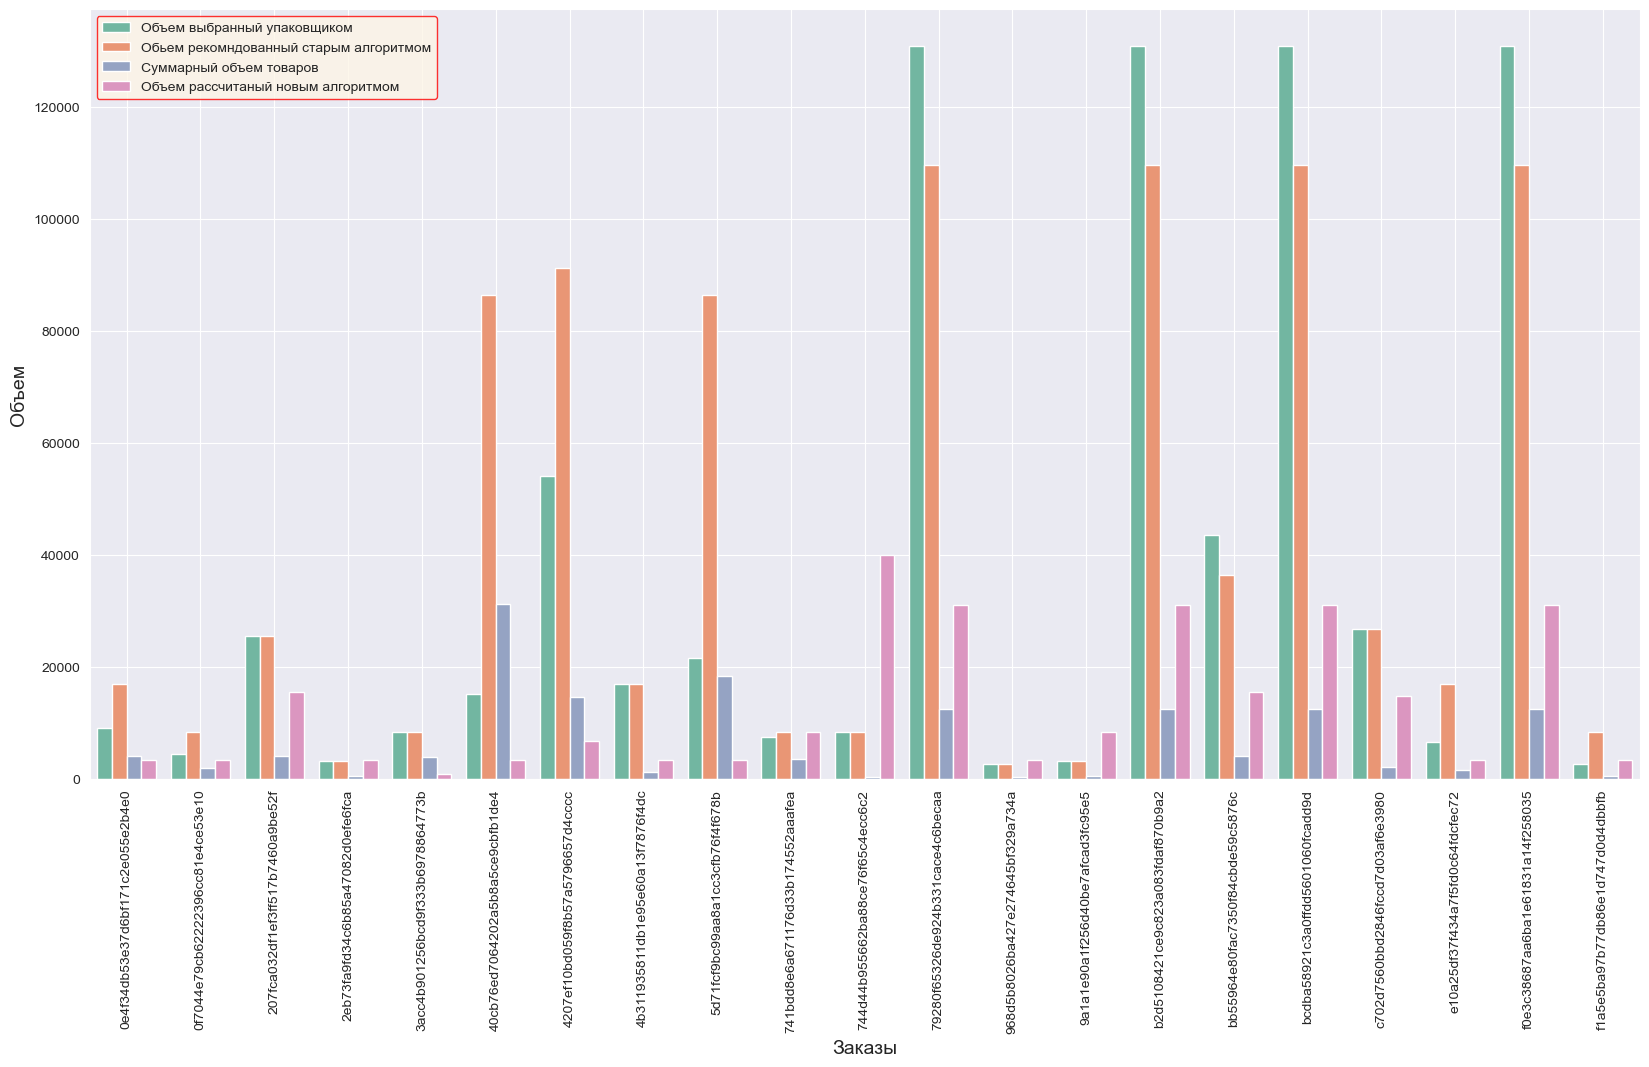

In [52]:
plt.figure(figsize=(20, 10))
sns.barplot(data=df_for_bar,
            x=df_for_bar.orderkey,
            y=df_for_bar.value,
            hue = 'variable',
            palette='Set2')
plt.ylabel('Объем', fontsize=14)
plt.xlabel('Заказы', fontsize=14)
plt.xticks(rotation=90)
plt.grid(True)
plt.legend(edgecolor = 'r',
           facecolor = 'oldlace');

**Благодаря тщательной компановке товаров новому алгоритму в большинстве случаев удалось рационализировать занимаемое при транспортровке место в равнение с старой рекомендательной ситемой и человеческим фактором. Кроме того, на графике присутсвуют аномалии, а именно 4 случая, где суммарный обьем товаров в заказе превышает объем рекомендованной упаковки. Рассмотрим эти случае подробно.**

**Выведем отдельно содержимое заказов.**

In [53]:
dct_wth_orders['3acc4b901256bcd9f333b6978864773b']

[{'bd4fcd43314a9b3e28cbf7ae22b3ece4': ['MYA', 'MYB', 'YMG']}]

In [54]:
dct_wth_orders['40cb76ed7064202a5b8a5ce9cbfb1de4']

[{'de2a4fb8e7834ab11f2a7bdf48c69482': ['MYB', 'NONPACK', 'MYA']}]

In [55]:
dct_wth_orders['4207ef10bd059f8b57a5796657d4cccc']

[{'e40f1c96a8de1baaa44fec15d7ae5268 e40f1c96a8de1baaa44fec15d7ae5268': ['MYB',
   'YMG',
   'MYD']},
 {'e40f1c96a8de1baaa44fec15d7ae5268 e40f1c96a8de1baaa44fec15d7ae5268': ['MYB',
   'YMG',
   'MYD']}]

In [56]:
dct_wth_orders['5d71fcf9bc99aa8a1cc3cfb76f4f678b']

[{'8560b5d4a4fe66486c568fab84a34b10': ['MYB', 'MYA', 'YMG']}]

**Посмотрим на количество товаров из заказа в общем датасете.**

In [57]:
for sku in ['bd4fcd43314a9b3e28cbf7ae22b3ece4', 'de2a4fb8e7834ab11f2a7bdf48c69482', 'e40f1c96a8de1baaa44fec15d7ae5268', '8560b5d4a4fe66486c568fab84a34b10']:
    print(f'Количетсво товаров с sku-{sku} в датасете -', len(df_data.query('sku == @sku')))

Количетсво товаров с sku-bd4fcd43314a9b3e28cbf7ae22b3ece4 в датасете - 6
Количетсво товаров с sku-de2a4fb8e7834ab11f2a7bdf48c69482 в датасете - 9
Количетсво товаров с sku-e40f1c96a8de1baaa44fec15d7ae5268 в датасете - 69
Количетсво товаров с sku-8560b5d4a4fe66486c568fab84a34b10 в датасете - 21


**Учитывая небольшое количество примеров в датасете с этими товарами, можно сделать вывод, что модель недообучилась. В дальнейшем, при большем наборе данных качество модели можно будет значительно улучшить.**

In [58]:
total_volume = for_analysis_by_order[['sel_calc_cube','rec_calc_cube','now_volume', 'total_volume_of_goods']].agg('sum').reset_index().rename(columns={'index': 'volume', 0: 'value'})

In [59]:
total_volume

,volume,value
0,sel_calc_cube,785071.000
1,rec_calc_cube,894936.000
2,now_volume,266486.600
3,total_volume_of_goods,144713.248


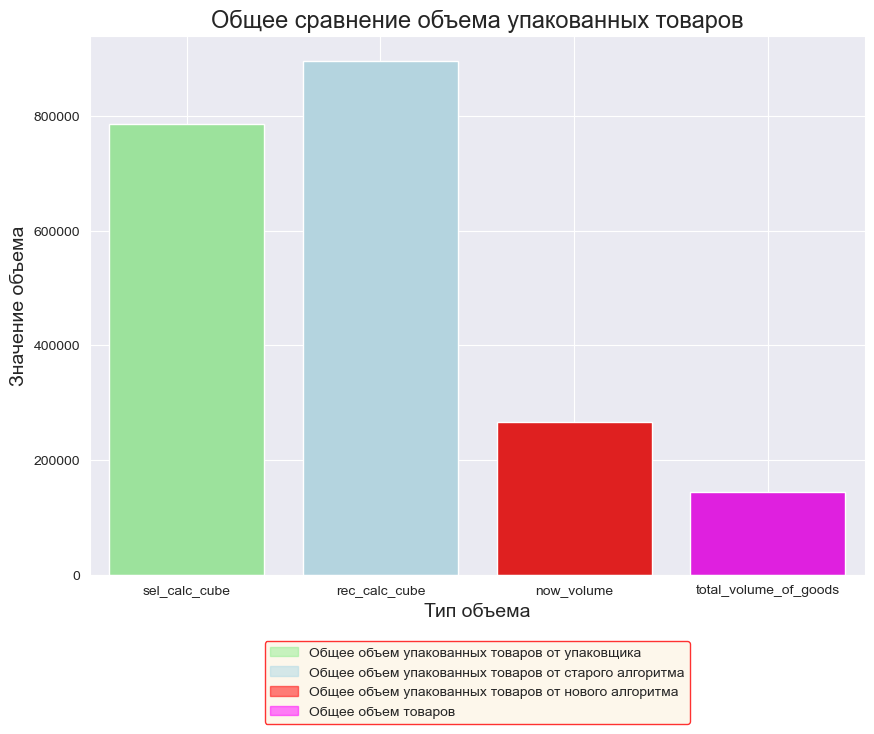

In [60]:
plt.figure(figsize=(10, 7))
plt.title('Общее сравнение объема упакованных товаров', fontsize=17)
sns.set_style('darkgrid')
sns.barplot(data=total_volume,
            x='volume',
            y='value',
            palette=['lightgreen', 'lightblue', 'red', 'magenta'])
plt.ylabel('Значение объема', fontsize=14)
plt.xlabel('Тип объема', fontsize=14)
plt.grid(True)
plt.legend(handles=[Patch(color='lightgreen', alpha=.5, label=f'Общее объем упакованных товаров от упаковщика'),
                    Patch(color='lightblue', alpha=.5, label=f'Общее объем упакованных товаров от старого алгоритма'),
                    Patch(color='red', alpha=.5, label=f'Общее объем упакованных товаров от нового алгоритма'),
                    Patch(color='magenta', alpha=.5, label=f'Общее объем товаров')],
           edgecolor = 'r',
           facecolor = 'oldlace', 
           loc='center',
           bbox_to_anchor=(0.5, -0.2));

**Новый алгоритм позволит значительно сэкономить место при транспортировке**

# Выводы

В результате проделанной работы был разработан алгоритм, позволяющий:

    1. Значительно зкономить место при транспортировке за счет компановки товаров в заказе.
    2. Снизить затраты на упаковку для товара/группы товаров.
    3. Иметь вариативность в выборе из нескольких предложенных для товаров упаковок, в случае если какой либо не   будет на складе.